![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/05.0.Clinical_Entity_Resolvers.ipynb)

📌 The license was provided and all necessary libraries and jars were installed when the EMR cluster was created.


In [1]:
from johnsnowlabs import nlp, medical

# Automatically load jars to the session
spark = nlp.start()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1694678399836_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spark Session already created, some configs may not take.
📋 Loading license number 0 from /lib/.johnsnowlabs/johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare.json

In [2]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Sentence Entity Resolver Models


A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

<img src="https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/data/Entity%20Resolution%20in%20Spark%20NLP%20for%20Healthcare.jpeg?raw=true" width="1000" alt="RxNorm Overview">

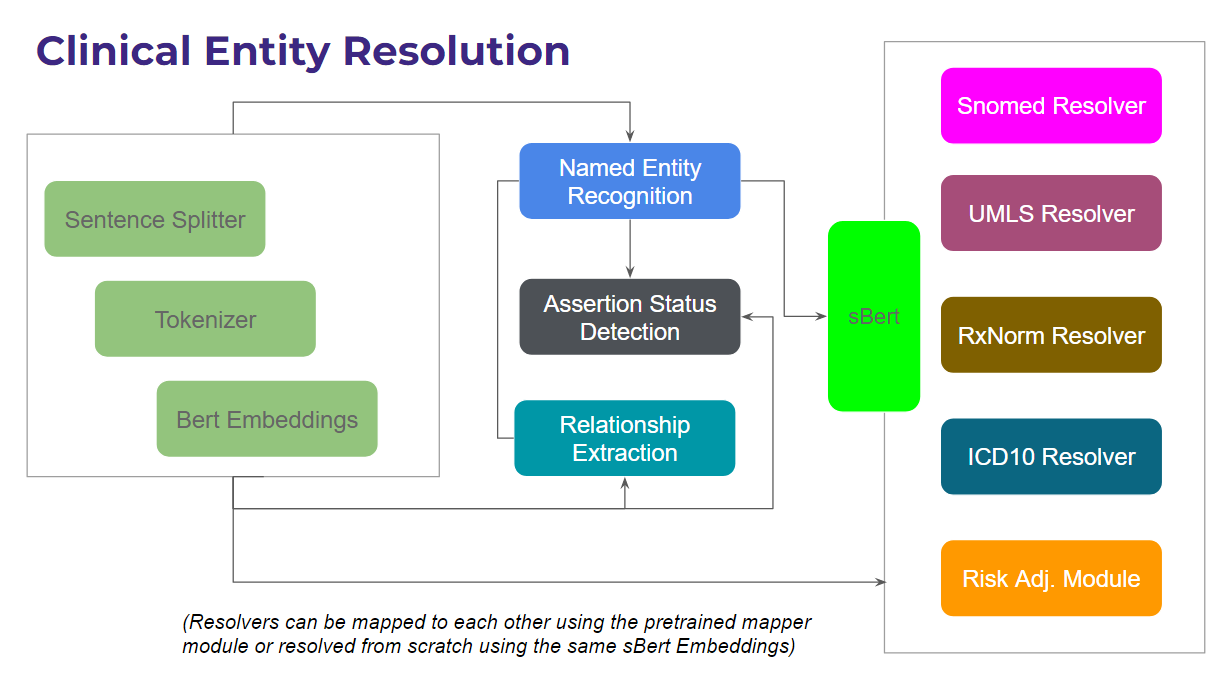

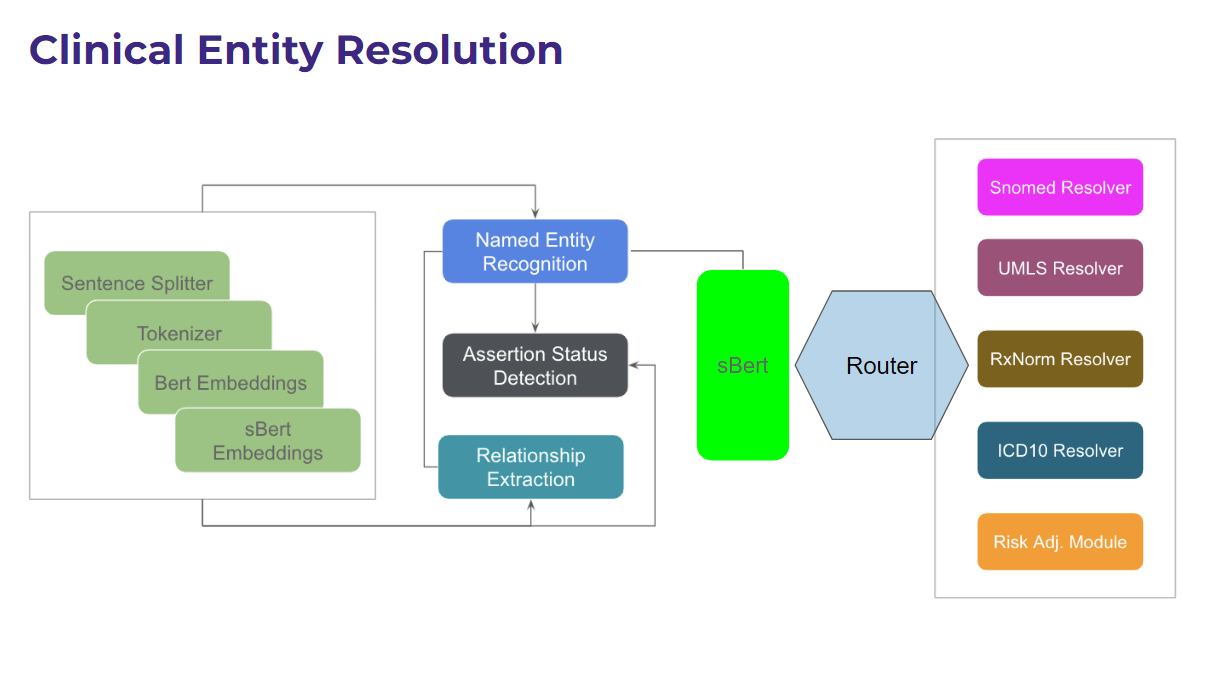

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We create a new pipeline that from each of these problems will try to assign an resolution on the content, the sentence embeddings and some pretrained models for resolver annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their resolutions.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexing of the first (for begin) and last (for end) tokens


<center><b>MODEL LIST</b>

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [sbertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_augmented_en.html)  | 2| [sbertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_augmented_billable_hcc_en.html)  | 3| [sbertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_slim_billable_hcc_en.html)  | 4| [sbertresolve_icd10cm_slim_billable_hcc_med](https://nlp.johnsnowlabs.com/2021/05/25/sbertresolve_icd10cm_slim_billable_hcc_med_en.html)  |
| 5| [sbertresolve_jsl_rxnorm_augmented_med](https://nlp.johnsnowlabs.com/2021/12/28/sbertresolve_jsl_rxnorm_augmented_med_en.html)  | 6| [sbertresolve_ner_model_finder](https://nlp.johnsnowlabs.com/2022/09/05/sbertresolve_ner_model_finder_en.html)  | 7| [sbertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_rxnorm_disposition_en.html)  | 8| [sbertresolve_snomed_bodyStructure_med](https://nlp.johnsnowlabs.com/2021/06/15/sbertresolve_snomed_bodyStructure_med_en.html)  |
| 9| [sbertresolve_snomed_conditions](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_snomed_conditions_en.html)  | 10| [sbiobert_jsl_rxnorm_cased](https://nlp.johnsnowlabs.com/2021/12/23/sbiobert_jsl_rxnorm_cased_en.html)  | 11| [sbiobertresolve_HPO](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_HPO_en.html)  | 12| [sbiobertresolve_atc](https://nlp.johnsnowlabs.com/2022/03/01/sbiobertresolve_atc_en_3_0.html)  |
| 13| [sbiobertresolve_clinical_abbreviation_acronym](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_clinical_abbreviation_acronym_en.html)  | 14| [sbiobertresolve_clinical_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/15/sbiobertresolve_clinical_snomed_procedures_measurements_en.html)  | 15| [sbiobertresolve_cpt](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_cpt_en.html)  | 16| [sbiobertresolve_cpt_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_augmented_en.html)  |
| 17| [sbiobertresolve_cpt_procedures_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_procedures_augmented_en.html)  | 18| [sbiobertresolve_cpt_procedures_measurements_augmented](https://nlp.johnsnowlabs.com/2022/05/10/sbiobertresolve_cpt_procedures_measurements_augmented_en_3_0.html)  | 19| [sbiobertresolve_cvx](https://nlp.johnsnowlabs.com/2022/10/12/sbiobertresolve_cvx_en.html)  | 20| [sbiobertresolve_hcc_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_hcc_augmented_en.html)  |
| 21| [sbiobertresolve_hcpcs](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html)  | 22| [sbiobertresolve_hgnc](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_hgnc_en.html)  | 23| [sbiobertresolve_icd10cm](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10cm_en.html)  | 24| [sbiobertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2021/10/31/sbiobertresolve_icd10cm_augmented_en.html)  |
| 25| [sbiobertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html)  | 26| [sbiobertresolve_icd10cm_generalised](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html)  | 27| [sbiobertresolve_icd10cm_generalised_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_icd10cm_generalised_augmented_en.html)  | 28| [sbiobertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_icd10cm_slim_billable_hcc_en.html)  |
| 29| [sbiobertresolve_icd10cm_slim_normalized](https://nlp.johnsnowlabs.com/2021/05/17/sbiobertresolve_icd10cm_slim_normalized_en.html)  | 30| [sbiobertresolve_icd10pcs](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html)  | 31| [sbiobertresolve_icd10pcs_augmented](https://nlp.johnsnowlabs.com/2022/10/28/sbiobertresolve_icd10pcs_augmented_en.html)  | 32| [sbiobertresolve_icd9](https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html)  |
| 33| [sbiobertresolve_icdo](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icdo_en.html)  | 34| [sbiobertresolve_icdo_augmented](https://nlp.johnsnowlabs.com/2021/06/22/sbiobertresolve_icdo_augmented_en.html)  | 35| [sbiobertresolve_icdo_base](https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html)  | 36| [sbiobertresolve_jsl_rxnorm_augmented](https://nlp.johnsnowlabs.com/2021/12/27/sbiobertresolve_jsl_rxnorm_augmented_en.html)  |
| 37| [sbiobertresolve_loinc](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_loinc_en.html)  | 38| [sbiobertresolve_loinc_augmented](https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html)  | 39| [sbiobertresolve_loinc_cased](https://nlp.johnsnowlabs.com/2021/12/24/sbiobertresolve_loinc_cased_en.html)  | 40| [sbiobertresolve_mesh](https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html)  |
| 41| [sbiobertresolve_ncit](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_ncit_en.html)  | 42| [sbiobertresolve_ndc](https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html)  | 43| [sbiobertresolve_rxcui](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html)  | 44| [sbiobertresolve_rxnorm](https://nlp.johnsnowlabs.com/2021/10/10/sbiobertresolve_rxnorm_en.html)  |
| 45| [sbiobertresolve_rxnorm_action_treatment](https://nlp.johnsnowlabs.com/2022/04/25/sbiobertresolve_rxnorm_action_treatment_en_2_4.html)  | 46| [sbiobertresolve_rxnorm_augmented](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_rxnorm_augmented_en.html)  | 47| [sbiobertresolve_rxnorm_augmented_cased](https://nlp.johnsnowlabs.com/2021/12/28/sbiobertresolve_rxnorm_augmented_cased_en.html)  | 48| [sbiobertresolve_rxnorm_augmented_re](https://nlp.johnsnowlabs.com/2022/02/09/sbiobertresolve_rxnorm_augmented_re_en.html)  |
| 49| [sbiobertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html)  | 50| [sbiobertresolve_rxnorm_ndc](https://nlp.johnsnowlabs.com/2021/10/05/sbiobertresolve_rxnorm_ndc_en.html)  | 51| [sbiobertresolve_rxnorm_nih](https://nlp.johnsnowlabs.com/2023/02/22/sbiobertresolve_rxnorm_nih_en.html)  | 52| [sbiobertresolve_snomed_auxConcepts](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_en.html)  |
| 53| [sbiobertresolve_snomed_auxConcepts_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_int_en.html)  | 54| [sbiobertresolve_snomed_bodyStructure](https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_bodyStructure_en.html)  | 55| [sbiobertresolve_snomed_drug](https://nlp.johnsnowlabs.com/2022/01/18/sbiobertresolve_snomed_drug_en.html)  | 56| [sbiobertresolve_snomed_findings](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_en.html)  |
| 57| [sbiobertresolve_snomed_findings_aux_concepts](https://nlp.johnsnowlabs.com/2022/02/26/sbiobertresolve_snomed_findings_aux_concepts_en_3_0.html)  | 58| [sbiobertresolve_snomed_findings_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_int_en.html)  | 59| [sbiobertresolve_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html)  | 60| [sbiobertresolve_umls_clinical_drugs](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html)  |
| 61| [sbiobertresolve_umls_disease_syndrome](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html)  | 62| [sbiobertresolve_umls_drug_substance](https://nlp.johnsnowlabs.com/2021/12/06/sbiobertresolve_umls_drug_substance_en.html)  | 63| [sbiobertresolve_umls_findings](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_findings_en.html)  | 64| [sbiobertresolve_umls_major_concepts](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html)  |
| 65| [sbluebertresolve_loinc](https://nlp.johnsnowlabs.com/2021/04/29/sbluebertresolve_loinc_en.html)  | 66| [sbluebertresolve_loinc_uncased](https://nlp.johnsnowlabs.com/2022/01/18/sbluebertresolve_loinc_uncased_en.html)  | 67| [sbluebertresolve_rxnorm_augmented_uncased](https://nlp.johnsnowlabs.com/2021/12/28/sbluebertresolve_rxnorm_augmented_uncased_en.html)  |

<br>
<br>

<b>PRETRAINED PIPELINE LIST</b>

|index|model|
|-----:|:-----|
| 1| [cvx_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/10/12/cvx_resolver_pipeline_en.html)  |
| 2| [icd10cm_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/11/02/icd10cm_resolver_pipeline_en.html)  |
| 3| [icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html)  |
| 4| [medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)  |
| 5| [medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)  |
| 6| [umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_clinical_findings_resolver_pipeline_en_3_0.html)  |
| 7| [umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_disease_syndrome_resolver_pipeline_en_3_0.html)  |
| 8| [umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_drug_resolver_pipeline_en_3_0.html)  |
| 9| [umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_drug_substance_resolver_pipeline_en_3_0.html)  |
| 10| [umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_major_concepts_resolver_pipeline_en_3_0.html)  |





</center>

You can find all resolver models and more on [Models Hub](https://nlp.johnsnowlabs.com/models?task=Entity+Resolution&edition=Spark+NLP+for+Healthcare) page.

### Helper Functions
Writing Generic Function For Getting the Codes and Relation Pairs

In [55]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

# returns LP resolution results

def get_codes (lp, text, vocab='icd10cm_code', hcc=False):

    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):

        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result)
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes,
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})

    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_code'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])

    df = df.drop(['all_k_aux_labels'], axis=1)

    return spark.createDataFrame(df)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# returns spark df resolution results

def get_codes_from_df(result_df, chunk, output_col, hcc= False):


    if hcc:

        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result',
                                                           chunk+'.metadata',
                                                           output_col+'.result',
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"),
                                             F.expr("cols['2']").alias("icd10_code"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                             F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()



        codes = []
        resolutions = []
        hcc_all = []

        for code, resolution, hcc in zip(df['all_codes'], df['resolutions'], df['hcc_list']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))
            hcc_all.append(hcc.split(":::"))

        df['all_codes'] = codes
        df['resolutions'] = resolutions
        df['hcc_list'] = hcc_all

    else:

        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result',
                                                           chunk+'.metadata',
                                                           output_col+'.result',
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"),
                                             F.expr("cols['2']").alias(f"{output_col}"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()



        codes = []
        resolutions = []

        for code, resolution in zip(df['all_codes'], df['resolutions']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))

        df['all_codes'] = codes
        df['resolutions'] = resolutions


    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# returns billable informations in distinct columns

def extract_billable(bil):

    billable = []
    status = []
    code = []

    for b in bil:
        billable.append(b.split("||")[0])
        status.append(b.split("||")[1])
        code.append(b.split("||")[2])

    return (billable, status, code)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# returns relation pair dataframe

def get_relations_df(results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append((
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2',
                                              'confidence'])

    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]

    return rel_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Sentence Entity Resolver (RxNorm)

- RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

- The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs.


<img src="https://www.nlm.nih.gov/research/umls/rxnorm/RxNorm_Drug_Relationships.png" width="750" alt="RxNorm Overview">

**Pretrained Models**

- `sbiobertresolve_rxnorm`
- `sbiobertresolve_rxnorm_dispo`
- `sbiobertresolve_rxnorm_disposition`
- `sbertresolve_rxnorm_disposition`
- `sbiobertresolve_rxnorm_ndc`
- `sbiobertresolve_rxnorm_augmented`
- `sbiobertresolve_rxnorm_augmented_re`

In [59]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = nlp.LightPipeline(rxnorm_pipelineModel)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]

In [60]:
text = 'metformin 100 mg'
get_codes(rxnorm_lp, text, vocab='rxnorm_code').show(truncate=45)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+---+-------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|          chunks|begin|end|   code|                                    all_codes|                                  resolutions|                                all_distances|
+----------------+-----+---+-------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|metformin 100 mg|    0| 15|2200518|[2200518, 861024, 141916, 334738, 332848, ...|[metformin hydrochloride 100 MG/ML Extende...|[0.0658, 0.0658, 0.0684, 0.0684, 0.0697, 0...|
+----------------+-----+---+-------+---------------------------------------------+---------------------------------------------+---------------------------------------------+

In [61]:
text = 'aspirin 10 meq/ 5 ml oral sol'

get_codes (rxnorm_lp, text, vocab='rxnorm_code').show(truncate=45)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|                       chunks|begin|end|  code|                                    all_codes|                                  resolutions|                                all_distances|
+-----------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|aspirin 10 meq/ 5 ml oral sol|    0| 28|996740|[996740, 991082, 997398, 636574, 794979, 9...|[memantine hydrochloride 2 MG/ML Oral Solu...|[0.0859, 0.0919, 0.0891, 0.0927, 0.0922, 0...|
+-----------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+

### RxNorm with DrugNormalizer

In [62]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk_v0")

drug_normalizer = medical.DrugNormalizer() \
    .setInputCols("ner_chunk_v0") \
    .setOutputCol("ner_chunk") \
    .setPolicy('all')

rxnorm_pipelineModel2 = nlp.PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = nlp.LightPipeline(rxnorm_pipelineModel2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
text = 'aspirin 10 meq/ 5 ml oral sol'

get_codes (rxnorm_lp2, text, vocab='rxnorm_code').show(truncate=45)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|                        chunks|begin|end|  code|                                    all_codes|                                  resolutions|                                all_distances|
+------------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|aspirin 2 meq/ml oral solution|    0| 29|688214|[688214, 342917, 688213, 755937, 756028, 9...|[aspirin 2.5 MG/ML Oral Solution, aspirin ...|[0.0347, 0.0566, 0.0748, 0.0947, 0.1040, 0...|
+------------------------------+-----+---+------+---------------------------------------------+---------------------------------------------+---------------------------------------------+

### Clinical Chunk Mapper Models

We can use sparknlp's Chunk Mapping feature to map clinical entities with their correspondings based on pre-defined dictionary. We have pretrained chunk mapping models that can be used through ChunkMapperModel() annotator, also, it is possible to create your own pretrained Chunk Mapper models by ChunkMapperApproach() annotator.

You can check [Healthcare Code Mapping Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/11.1.Healthcare_Code_Mapping.ipynb) for the examples of pretrained mapper pipelines.


Lets show an example of `rxnorm_mapper` model that maps entities with their corresponding RxNorm codes.

In [64]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("rxnorm")\
    .setRels(["rxnorm_code"])


mapper_pipeline = nlp.Pipeline().setStages([document_assembler, chunkerMapper])
mapper_model = mapper_pipeline.fit(spark.createDataFrame([['']]).toDF('text'))

mapper_lp = nlp.LightPipeline(mapper_model)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rxnorm_mapper download started this may take some time.
[OK!]

In [65]:
mapper_lp.fullAnnotate("metformin")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'ner_chunk': [Annotation(document, 0, 8, metformin, {}, [])], 'rxnorm': [Annotation(labeled_dependency, 0, 8, 6809, {'__trained__': 'metformin', 'relation': 'rxnorm_code', 'all_k_distances': '0.0:::0.0', '__distance_function__': 'levenshtein', 'all_k_resolutions': '6809:::', 'target_text': 'metformin', 'ops': '0.0', 'all_relations': '', 'entity': 'metformin', 'resolved_text': '6809', '__deprecation_notice__': '`keyRelation`, `entity`, `relation` and `all_relations` keys are being deprecated; use special relation __relation_name__, target_text, resolved_text and all_k_resolutions keys instead.', 'distance': '0.0', '__relation_name__': 'rxnorm_code'}, [])]}]

### Drug Spell Checker

In [66]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols("document")\
    .setOutputCol("token")

spell = nlp.NorvigSweetingModel.pretrained("spellcheck_drug_norvig", "en", "clinical/models")\
    .setInputCols("token")\
    .setOutputCol("corrected_token")\

pipeline = nlp.Pipeline(stages = [documentAssembler,
                              tokenizer,
                              spell])

model = pipeline.fit(spark.createDataFrame([['']]).toDF('text'))
lp = nlp.LightPipeline(model)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

spellcheck_drug_norvig download started this may take some time.
Approximate size to download 4.3 MB
[OK!]

In [67]:
text = "You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril"

corrected = lp.annotate(text)

print(" ".join(corrected['token']))
print(" ".join(corrected['corrected_token']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril
You have to take Neutracare and colfosinum and a bit of Fluorometholone & Rivotril

## Sentence Entity Resolver (ICD-10CM)

###  ICD10 background info

**ICD-10-CM vs. ICD-10-PCS**

- With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

- **The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

- ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

- ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

- ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

- When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

**ICD-10-CM breakdown**

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


**ICD-10-PCS breakdown**

- Will replace ICD-9-CM for hospital inpatient use only.
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”
- 7 alphanumeric characters

- ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

- Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

- Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

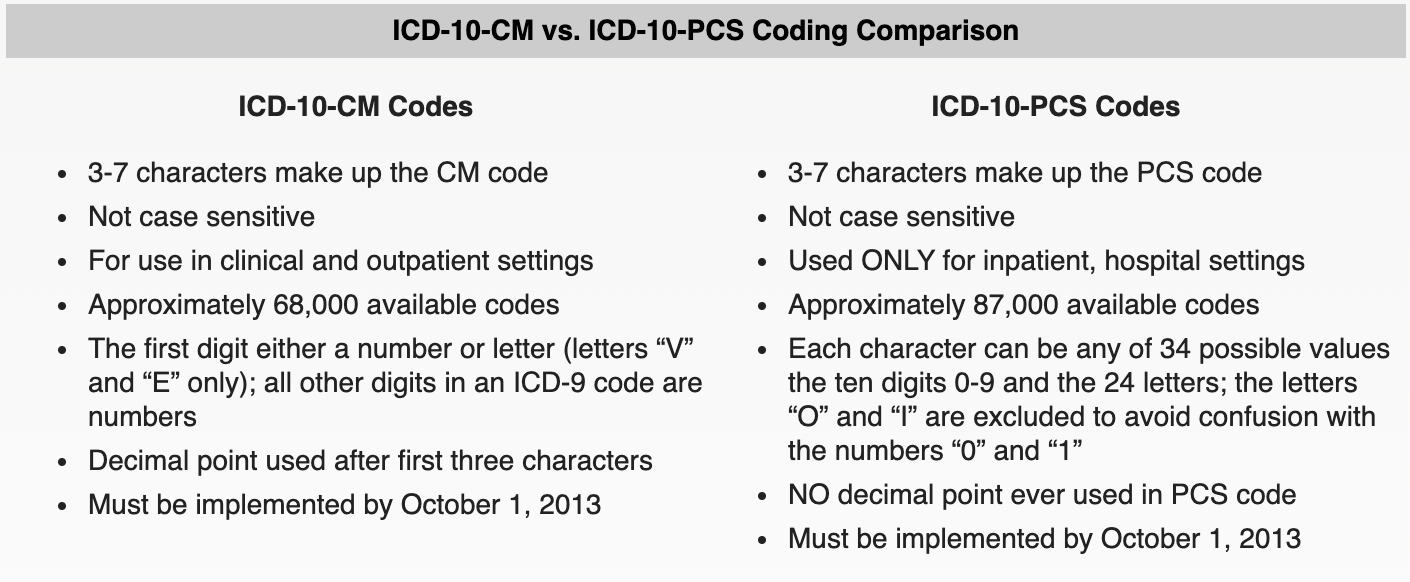

**Pretrained ICD-10 Models**

- `sbiobertresolve_icd10cm_augmented`
- `sbiobertresolve_icd10pcs`
- `sbiobertresolve_icd10cm_augmented_billable_hcc`
- `sbiobertresolve_icd10cm`
- `sbiobertresolve_icd10cm_slim_normalized`
- `sbiobertresolve_icd10cm_slim_billable_hcc`
- `sbertresolve_icd10cm_slim_billable_hcc_med`
- `sbiobertresolve_icd10cm_generalised`

### Creating ICD-10CM Pipeline

In [68]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Named Entity Recognition for clinical concepts.
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_converter_icd = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['PROBLEM'])\
    .setPreservePosition(False)

c2doc = nlp.Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("doc_ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


# Build up the pipeline
resolver_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model = resolver_pipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]

**Create a SparkDataFrame with the content**

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [69]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness or guarding. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission.')

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
data_ner.show(truncate = 100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+

In [71]:
icd10_result = model.transform(data_ner)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
icd10_result.select("icd10cm_code.metadata").show(truncate=100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------------------------------------------------+
|                                                                                            metadata|
+----------------------------------------------------------------------------------------------------+
|[{chunk -> 0, all_k_results -> O24.4:::O24.41:::O24.43:::Z86.32:::Z87.5:::O24.31:::O24.11:::O24.1...|
+----------------------------------------------------------------------------------------------------+

In [79]:
res_pd = get_codes_from_df(icd10_result, 'ner_chunk', 'icd10cm_code', hcc=True)
spark.createDataFrame(res_pd.head()).show(truncate=35)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------------------------+-------+----------+-----------------------------------+-----------------------------------+-----------------------------------+
|sent_id|                          ner_chunk| entity|icd10_code|                          all_codes|                        resolutions|                           hcc_list|
+-------+-----------------------------------+-------+----------+-----------------------------------+-----------------------------------+-----------------------------------+
|      0|      gestational diabetes mellitus|PROBLEM|     O24.4|[O24.4, O24.41, O24.43, Z86.32, ...|[gestational diabetes mellitus [...|[0||0||0, 0||0||0, 0||0||0, 1||0...|
|      0|subsequent type two diabetes mel...|PROBLEM|    O24.11|[O24.11, E11.8, E11, E13.9, E11....|[pre-existing type 2 diabetes me...|[0||0||0, 1||1||18, 0||0||0, 1||...|
|      0|                 an acute hepatitis|PROBLEM|       B15|[B15, K72.0, B17.9, B17.2, Z03.8...|[acute hepatitis a [acute hepati...

In [80]:
res_pd["billable"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_pd["hcc_status"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_pd["hcc_code"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_pd.drop("hcc_list", axis=1, inplace= True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
spark.createDataFrame(res_pd.head(15)).show(truncate=20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sent_id|           ner_chunk| entity|icd10_code|           all_codes|         resolutions|            billable|          hcc_status|            hcc_code|
+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      0|gestational diabe...|PROBLEM|     O24.4|[O24.4, O24.41, O...|[gestational diab...|[0, 0, 0, 1, 0, 0...|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|
|      0|subsequent type t...|PROBLEM|    O24.11|[O24.11, E11.8, E...|[pre-existing typ...|[0, 1, 0, 1, 1, 0...|[0, 1, 0, 1, 1, 0...|[0, 18, 0, 19, 19...|
|      0|  an acute hepatitis|PROBLEM|       B15|[B15, K72.0, B17....|[acute hepatitis ...|[0, 0, 1, 1, 1, 1...|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|
|      0|             obesity|PROBLEM|     E66.9|[E66.9, E66.8, Z6...|

Lets apply some HTML formating by using `sparknlp_display` library to see the results of the pipeline in a nicer layout:

📌 Since notebook runs on EMR cluster, we can display visualization on local by saving the visualization html.

In [88]:
icd10_lp = nlp.LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

#visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')
visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code',save_path="/tmp/display_result.html")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<IPython.core.display.HTML object>

In [89]:
%%local
from IPython.display import display,HTML
with open("/tmp/display_result.html",'r') as display_result:
    display(HTML(display_result.read()))

### ICD10CM with BertSentenceChunkEmbeddings

**BertSentenceChunkEmbeddings**

- This annotator let users to aggregate sentence embeddings and ner chunk embeddings to get more specific and accurate resolution codes. It works by averaging context and chunk embeddings to get contextual information. Input to this annotator is the context (sentence) and ner chunks, while the output is embedding for each chunk that can be fed to the resolver model. The `setChunkWeight` parameter can be used to control the influence of surrounding context.

- For more information and examples of `BertSentenceChunkEmbeddings` annotator, you can check here:
[24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

Lets do the same process by using `BertSentenceEmbeddings` annotator and compare the results. We will create a new pipeline by using this annotator with SentenceEntityResolverModel.

In [90]:
#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = medical.BertSentenceChunkEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)\
    .setChunkWeight(0.5) #default : 0.5

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline_SCE = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        sentence_chunk_embeddings,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model_SCE = resolver_pipeline_SCE.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]

In [91]:
model.stages

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[DocumentAssembler_2e172a0c0714, SentenceDetectorDLModel_6bafc4746ea5, REGEX_TOKENIZER_617f3ba53fdc, WORD_EMBEDDINGS_MODEL_9004b1d00302, MedicalNerModel_cd5ce67b529f, NER_CONVERTER_290f17c0f192, Chunk2Doc_18a9ebf119d2, BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc, ENTITY_05f90ef679b8]

In [92]:
model_SCE.stages

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[DocumentAssembler_2e172a0c0714, SentenceDetectorDLModel_6bafc4746ea5, REGEX_TOKENIZER_918a8ea428ea, WORD_EMBEDDINGS_MODEL_9004b1d00302, MedicalNerModel_cd5ce67b529f, NER_CONVERTER_fd785c634ac1, BERTSENTENCECHUNKEMBEDDINGS_c6dca4c9e74c, ENTITY_05f90ef679b8]

In [94]:
icd10_result_SCE = model_SCE.transform(data_ner)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
res_SCE_pd = get_codes_from_df(icd10_result_SCE, 'ner_chunk', 'icd10cm_code', hcc=True)

res_SCE_pd["billable"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_SCE_pd["hcc_status"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_SCE_pd["hcc_code"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_SCE_pd.drop("hcc_list", axis=1, inplace= True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
spark.createDataFrame(res_SCE_pd.head(15)).show(truncate=20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sent_id|           ner_chunk| entity|icd10_code|           all_codes|         resolutions|            billable|          hcc_status|            hcc_code|
+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      0|gestational diabe...|PROBLEM|     O24.4|[O24.4, O24.43, O...|[gestational diab...|[0, 0, 0, 1, 0, 1...|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|
|      0|subsequent type t...|PROBLEM|    O24.13|[O24.13, E11.6, E...|[pre-existing typ...|[1, 0, 1, 0, 1, 0...|[0, 0, 1, 0, 1, 0...|[0, 0, 18, 0, 17,...|
|      0|  an acute hepatitis|PROBLEM|     B16.9|[B16.9, B15.9, B1...|[acute fulminatin...|[1, 1, 1, 1, 1, 1...|[0, 0, 0, 0, 0, 1...|[0, 0, 0, 0, 0, 2...|
|      0|             obesity|PROBLEM|    O99.21|[O99.21, E23.3, E...|

Lets show the results on the raw text.

In [97]:
icd10_SCE_lp = nlp.LightPipeline(model_SCE)

light_result = icd10_SCE_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

#visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')
visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code',save_path="/tmp/display_sce_result.html")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<IPython.core.display.HTML object>

In [98]:
%%local
from IPython.display import display,HTML
with open("/tmp/display_sce_result.html",'r') as display_sce_result:
    display(HTML(display_sce_result.read()))

Lets compare the results that we got from these two methods.

In [103]:
sentence_df = icd10_result.select(F.explode(F.arrays_zip(icd10_result.sentence.metadata,
                                                         icd10_result.sentence.result)).alias("cols")) \
                          .select(F.expr("cols['0']['sentence']").alias("sent_id"),
                                  F.expr("cols['1']").alias("sentence_all")).toPandas()

comparison_df = pd.merge(res_pd.loc[:,'sent_id':'resolutions'],res_SCE_pd.loc[:,'sent_id':'resolutions'], on=['sent_id',"ner_chunk", "entity"], how='inner')
comparison_df.columns=['sent_id','ner_chunk', 'entity', 'icd10_code', 'all_codes', 'resolutions', 'icd10_code_SCE', 'all_codes_SCE', 'resolutions_SCE']

comparison_df = pd.merge(sentence_df, comparison_df,on="sent_id").drop('sent_id', axis=1)
spark.createDataFrame(comparison_df.head(15)).show(truncate=20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------+----------+--------------------+--------------------+--------------+--------------------+--------------------+
|        sentence_all|           ner_chunk| entity|icd10_code|           all_codes|         resolutions|icd10_code_SCE|       all_codes_SCE|     resolutions_SCE|
+--------------------+--------------------+-------+----------+--------------------+--------------------+--------------+--------------------+--------------------+
|A 28-year-old fem...|gestational diabe...|PROBLEM|     O24.4|[O24.4, O24.41, O...|[gestational diab...|         O24.4|[O24.4, O24.43, O...|[gestational diab...|
|A 28-year-old fem...|subsequent type t...|PROBLEM|    O24.11|[O24.11, E11.8, E...|[pre-existing typ...|        O24.13|[O24.13, E11.6, E...|[pre-existing typ...|
|A 28-year-old fem...|  an acute hepatitis|PROBLEM|       B15|[B15, K72.0, B17....|[acute hepatitis ...|         B16.9|[B16.9, B15.9, B1...|[acute fulminatin...|
|A 28-year-old fem...|      

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

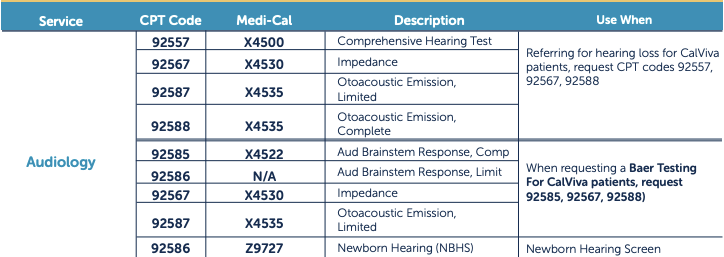

**Pretrained Models**

- `sbiobertresolve_cpt`
- `sbiobertresolve_cpt_augmented`
- `sbiobertresolve_cpt_procedures_augmented`
- `sbiobertresolve_cpt_procedures_measurements_augmented`

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [104]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")


pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = medical.NerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "word_embeddings"]) \
   .setOutputCol("ner")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = medical.RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["word_embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)


# Build up the pipeline
relation_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
[OK!]
re_bodypart_directions download started this may take some time.
[OK!]

In [105]:
light_rel_model = nlp.LightPipeline(rel_model)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       entity1 chunk1   entity2  chunk2 confidence
0  ImagingTest  x-ray  BodyPart  fibula  1.0      
1  ImagingTest  x-ray  BodyPart  knee    0.9458425

**Now we can use get CPT codes of these related chunks.**

In [107]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

cpt_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = nlp.LightPipeline(cpt_pipelineModel)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
[OK!]

In [113]:
text = 'fibula x-ray'

get_codes (cpt_lp, text, vocab='cpt_code').show(truncate=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|      chunks|begin|end| code|                                         all_codes|                                       resolutions|                                     all_distances|
+------------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|fibula x-ray|    0| 11|73590|[73590, 27676, 27455, 27712, 27457, 27707, 7355...|[Tibia and fibula X-ray, Incision of fibula, In...|[0.0895, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970...|
+------------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+

In [114]:
text = 'knee x-ray'

get_codes (cpt_lp, text, vocab='cpt_code').show(truncate=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|    chunks|begin|end| code|                                         all_codes|                                       resolutions|                                     all_distances|
+----------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|knee x-ray|    0|  9|73564|[73564, 73562, 73580, 27486, 1010487, 27540, 27...|[Knee X-ray, Knee X-ray, Knee arthrogram, Knee ...|[0.0000, 0.0000, 0.0907, 0.1096, 0.1171, 0.1309...|
+----------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+

In [115]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    entity1 chunk1      entity2               chunk2 confidence
0  BodyPart  chest  ImagingTest  portable ultrasound  0.9999802

In [119]:
text = 'chest portable ultrasound'

get_codes (cpt_lp, text, vocab='cpt_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|                   chunks|begin|end|   code|                               all_codes|                             resolutions|                           all_distances|
+-------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|chest portable ultrasound|    0| 24|1010771|[1010771, 76512, 76510, 3320F, 76977,...|[Diagnostic Ultrasound Procedures of ...|[0.1269, 0.1563, 0.1563, 0.1582, 0.15...|
+-------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+

In [120]:
text="This 73 y/o patient had Brain CT on 1/12/95, with progressive memory and cognitive decline since 8/11/94."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    entity1 chunk1      entity2 chunk2 confidence
0  BodyPart  Brain  ImagingTest  CT     0.9999999

In [121]:
text = 'brain CT'

get_codes (cpt_lp, text, vocab='cpt_code').show(truncate=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|  chunks|begin|end| code|                                         all_codes|                                       resolutions|                                     all_distances|
+--------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|brain CT|    0|  7|78607|[78607, 70559, 70551, 70552, 3111F, 70553, 3112...|[Cerebral scan, MRI of brain, MRI of brain, MRI...|[0.1437, 0.1555, 0.1555, 0.1555, 0.1555, 0.1555...|
+--------+-----+---+-----+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+

## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association.

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

**Pretrained SNOMED Resolver Models**

- `sbiobertresolve_snomed_auxConcepts_int`
- `sbiobertresolve_snomed_findings`
- `sbiobertresolve_snomed_findings_int`
- `sbiobertresolve_snomed_auxConcepts`
- `sbiobertresolve_snomed_procedures_measurements`
- `sbertresolve_snomed_bodyStructure_med`
- `sbiobertresolve_snomed_bodyStructure`
- `sbiobertresolve_snomed_findings_aux_concepts`
- `sbertresolve_snomed_conditions`
- `sbiobertresolve_snomed_drug`

In [122]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

snomed_ct_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = nlp.LightPipeline(snomed_pipelineModel)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
[OK!]

In [123]:
text = 'brain tumor'

get_codes (snomed_lp, text, vocab='snomed_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+
|     chunks|begin|end|     code|                               all_codes|                             resolutions|                           all_distances|
+-----------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+
|brain tumor|    0| 10|254935002|[254935002, 363356001, 254936001, 275...|[brain tumor, malignant brain tumor, ...|[0.0000, 0.0447, 0.0719, 0.0827, 0.08...|
+-----------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+

In [124]:
text = 'chest pain on left side'

get_codes (snomed_lp, text, vocab='snomed_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+
|                 chunks|begin|end|     code|                               all_codes|                             resolutions|                           all_distances|
+-----------------------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+
|chest pain on left side|    0| 22|285385002|[285385002, 427293006, 15743561000119...|[left sided chest pain, pain radiatin...|[0.0212, 0.0261, 0.0475, 0.0480, 0.04...|
+-----------------------+-----+---+---------+----------------------------------------+----------------------------------------+----------------------------------------+

## Sentence Entity Resolver (LOINC)

- Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

- It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

- LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

**Pretrained LOINC Resovler Models**

- `sbiobertresolve_loinc`
- `sbiobertresolve_loinc_cased`
- `sbiobertresolve_loinc_augmented`
- `sbluebertresolve_loinc`
- `sbluebertresolve_loinc_uncased`




In [125]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

loinc_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("loinc_code")\
    .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = nlp.LightPipeline(loinc_pipelineModel)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc_augmented download started this may take some time.
[OK!]

In [128]:
text = 'FLT3 gene mutation analysis'

get_codes (loinc_lp, text, vocab='loinc_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|                     chunks|begin|end|   code|                               all_codes|                             resolutions|                           all_distances|
+---------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|FLT3 gene mutation analysis|    0| 26|47958-4|[47958-4, LP310331-6, 21676-2, 53863-...|[FLT3 gene targeted mutation analysis...|[0.0354, 0.1032, 0.1021, 0.1111, 0.11...|
+---------------------------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+

In [129]:
text = 'Hematocrit'

get_codes (loinc_lp, text, vocab='loinc_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|    chunks|begin|end|   code|                               all_codes|                             resolutions|                           all_distances|
+----------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+
|Hematocrit|    0|  9|11151-8|[11151-8, 16931-8, 32354-3, 20570-8, ...|[Hematocrit [Hematocrit], Hematocrit/...|[0.0000, 0.0506, 0.0590, 0.0625, 0.06...|
+----------+-----+---+-------+----------------------------------------+----------------------------------------+----------------------------------------+

## Sentence Entity Resolver (UMLS)

- Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

- The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

- The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

**Pretrained Models**

- `sbiobertresolve_umls_findings`
- `sbiobertresolve_umls_major_concepts`
- `sbiobertresolve_umls_disease_syndrome`
- `sbiobertresolve_umls_clinical_drugs`

In [130]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

umls_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("umls_code")\
    .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = nlp.PipelineModel(stages = [
    documentAssembler,
    sbert_embedder,
    umls_resolver])

umls_lp = nlp.LightPipeline(umls_pipelineModel)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
[OK!]

In [131]:
# Injuries & poisoning
text = 'food poisoning'

get_codes (umls_lp, text, vocab='umls_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+
|        chunks|begin|end|    code|                               all_codes|                             resolutions|                           all_distances|
+--------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+
|food poisoning|    0| 13|C0016479|[C0016479, C0349783, C0411266, C01784...|[food poisoning, infectious food pois...|[0.0000, 0.0507, 0.0660, 0.0668, 0.08...|
+--------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+

In [132]:
# clinical findings
text = 'type two diabetes mellitus'

get_codes (umls_lp, text, vocab='umls_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+
|                    chunks|begin|end|    code|                               all_codes|                             resolutions|                           all_distances|
+--------------------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+
|type two diabetes mellitus|    0| 25|C4014362|[C4014362, C3532488, C1320657, C13139...|[type 2 diabetes mellitus (t2d), hist...|[0.0438, 0.0568, 0.0618, 0.0697, 0.07...|
+--------------------------+-----+---+--------+----------------------------------------+----------------------------------------+----------------------------------------+

## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [133]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

hpo_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("hpo_code")\
    .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = nlp.LightPipeline(hpo_pipelineModel)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
[OK!]

In [135]:
text = 'schizophrenia '

get_codes(hpo_lp, text, vocab='hpo_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|        chunks|begin|end|      code|                               all_codes|                             resolutions|                           all_distances|
+--------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|schizophrenia |    0| 13|HP:0100753|[HP:0100753, HP:0000709, HP:0007302, ...|[schizophrenia, psychosis, bipolar di...|[0.0000, 0.1172, 0.1488, 0.1599, 0.18...|
+--------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+

In [136]:
text = 'Abnormality of the upper limb'

get_codes (hpo_lp, text, vocab='hpo_code').show(truncate=40)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|                       chunks|begin|end|      code|                               all_codes|                             resolutions|                           all_distances|
+-----------------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|Abnormality of the upper limb|    0| 28|HP:0002817|[HP:0002817, HP:0001454, HP:0009810, ...|[abnormality of the upper limb, abnor...|[0.0000, 0.0141, 0.0195, 0.0423, 0.04...|
+-----------------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+

In [137]:
text = 'Muscle haemorrhage'

get_codes (hpo_lp, text, vocab='hpo_code').show(truncate=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|            chunks|begin|end|      code|                               all_codes|                             resolutions|                           all_distances|
+------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|Muscle haemorrhage|    0| 17|HP:0040242|[HP:0040242, HP:0012233, HP:0040223, ...|[muscle haemorrhage, intramuscular he...|[0.0000, 0.0749, 0.1115, 0.1187, 0.12...|
+------------------+-----+---+----------+----------------------------------------+----------------------------------------+----------------------------------------+

## Assertion Filterer - Using with Resolvers


We can determine the **assertion status** of the entities and filter by `present` with `AssertionFilterer` and then use it in the **Resolver** model.

In [138]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Problem"])

clinical_assertion = medical.AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = medical.AssertionFilterer()\
    .setInputCols("sentence","ner_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setCaseSensitive(False)\
    .setWhiteList(["Present"])

c2doc = nlp.Chunk2Doc()\
    .setInputCols("assertion_filtered")\
    .setOutputCol("doc_ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

nlpPipeline = nlp.Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      clinical_assertion,
      assertion_filterer,
      c2doc,
      sbert_embedder,
      icd_resolver
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
assertionFilter_model = nlpPipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
assertion_dl download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]

In [139]:
clinical_note = ["""
Patient with severe fever and sore throat.  He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs. After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""]

light_model = nlp.LightPipeline(assertionFilter_model)

light_result = light_model.fullAnnotate(clinical_note)[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
light_result.keys()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

dict_keys(['assertion_filtered', 'document', 'ner_chunk', 'assertion', 'sentence_embeddings', 'icd10cm_code', 'token', 'ner', 'embeddings', 'doc_ner_chunk', 'sentence'])

In [141]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m, n in zip(light_result['ner_chunk'],light_result["assertion"] ):

    chunks.append(m.result)
    entities.append(m.metadata['entity'])
    status.append(n.result)
    confidence.append(n.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            chunks entities                     assertion confidence
0  severe fever     PROBLEM  present                       1.0      
1  sore throat      PROBLEM  present                       1.0      
2  stomach pain     PROBLEM  absent                        0.8322   
3  pain control     PROBLEM  hypothetical                  0.9441   
4  short of breath  PROBLEM  conditional                   0.9895   
5  lung tumor       PROBLEM  present                       0.9961   
6  Alzheimer        PROBLEM  associated_with_someone_else  0.996

In [142]:
#from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

#visualiser.display(light_result, 'ner_chunk', 'icd10cm_code')
visualiser.display(light_result, 'ner_chunk', 'icd10cm_code',save_path="/tmp/display_light_result.html")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<IPython.core.display.HTML object>

In [143]:
%%local
from IPython.display import display,HTML
with open("/tmp/display_light_result.html",'r') as display_light_result:
    display(HTML(display_light_result.read()))

In [144]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m in light_result["assertion_filtered"] :

    chunks.append(m.result)
    entities.append(m.metadata['entity'])
    status.append(m.metadata['assertion'])
    confidence.append(m.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         chunks entities assertion confidence
0  severe fever  PROBLEM  present   0.902    
1  sore throat   PROBLEM  present   0.98815  
2  lung tumor    PROBLEM  present   0.9019

In [145]:
#from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})
#visualiser.display(light_result, 'assertion_filtered', 'icd10cm_code')

visualiser.display(light_result, 'assertion_filtered', 'icd10cm_code',save_path="/tmp/display_icd10cm_result.html")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<IPython.core.display.HTML object>

In [146]:
%%local
from IPython.display import display,HTML
with open("/tmp/display_icd10cm_result.html",'r') as display_icd10cm_result:
    display(HTML(display_icd10cm_result.read()))

## Router - Using Resolver Models Together

- Normally, when we need to use more than one sentence entity resolver models in the same pipeline, we used to hit `BertSentenceEmbeddings` annotator more than once given the number of different resolver models in the same pipeline. Now we are introducing a solution with the help of `Router` annotator that could allow us to feed all the NER chunks to `BertSentenceEmbeddings` at once and then route the output of Sentence Embeddings to different resolver models needed.

- In this example, lets use `sbiobertresolve_rxnorm` RxNorm model and `sbiobertresolve_icd10cm_slim_billable_hcc` ICD10CM-HCC models together. First we will get the `PROBLEM` entities form `ner_clinical` model and then get the `DRUG` entities from `ner_posology` model. Then we will merge them and use the `Chunk2Doc` annotator to create sentence chunks to populate Sentence Embeddings column. Then, we route the embeddings of `PROBLEM` entities to ICD10CM model and embeddings of `DRUG` entities to RxNorm model at the same time.

In [147]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetector()\
    .setInputCols("document")\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("word_embeddings")

# to get PROBLEM entitis
clinical_ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("clinical_ner")

clinical_ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","clinical_ner")\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["PROBLEM"])

# to get DRUG entities
posology_ner = medical.NerModel().pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("posology_ner")

posology_ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","posology_ner")\
    .setOutputCol("posology_ner_chunk")\
    .setWhiteList(["DRUG"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("clinical_ner_chunk","posology_ner_chunk")\
    .setOutputCol("final_ner_chunk")\
    .setMergeOverlapping(False)


# convert chunks to doc to get sentence embeddings of them
chunk2doc = nlp.Chunk2Doc().setInputCols("final_ner_chunk").setOutputCol("doc_final_chunk")


sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_final_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

# filter PROBLEM entity embeddings
router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

# filter DRUG entity embeddings
router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["DRUG"]) \
    .setOutputCol("drug_embeddings")

# use problem_embeddings only
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


# use drug_embeddings only
rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")


pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    clinical_ner_chunk,
    posology_ner,
    posology_ner_chunk,
    chunk_merger,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
model = pipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]

In [148]:
clinical_note = """The patient is a 41-year-old Vietnamese female with a cough that started last week.
She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis in May 2006 and developed cough with right-sided chest pain.
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
"""

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [149]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

result = model.transform(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [150]:
icd10_result = get_codes_from_df(result, 'clinical_ner_chunk', 'icd10cm_code', hcc=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [151]:
# extract HCC informationinto different columns

icd10_result["billable"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
icd10_result["hcc_status"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_result["hcc_code"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_result.drop("hcc_list", axis=1, inplace= True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [153]:
spark.createDataFrame(icd10_result.head(15)).show(truncate=20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sent_id|           ner_chunk| entity|icd10_code|           all_codes|         resolutions|            billable|          hcc_status|            hcc_code|
+-------+--------------------+-------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      0|             a cough|PROBLEM|       R05|[R05, R05.3, R05....|[cough [cough], c...|[0, 1, 1, 0, 1, 1...|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|
|      1|right-sided chest...|PROBLEM|    R10.11|[R10.11, M79.621,...|[right upper quad...|[1, 1, 1, 1, 1, 1...|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|
|      1|               fever|PROBLEM|       A68|[A68, A78, R50.2,...|[relapsing fevers...|[0, 1, 1, 1, 1, 1...|[0, 0, 0, 1, 0, 0...|[0, 0, 0, 40, 0, ...|
|      2|        pericarditis|PROBLEM|     I30.1|[I30.1, B33.23, I...|

Now lets get RxNorm codes from our results.

In [155]:
rxnorm_result = get_codes_from_df(result, 'posology_ner_chunk', 'rxnorm_code', hcc=False)

spark.createDataFrame(rxnorm_result.head()).show(truncate=20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------+-----------+--------------------+--------------------+
|sent_id| ner_chunk|entity|rxnorm_code|           all_codes|         resolutions|
+-------+----------+------+-----------+--------------------+--------------------+
|      4|  Coumadin|  DRUG|     202421|[202421, 374998, ...|[Coumadin, coumar...|
|      6|Amiodarone|  DRUG|        703|[703, 1663223, 11...|[amiodarone, amio...|
+-------+----------+------+-----------+--------------------+--------------------+

### Using Router with Single NER Model

**If we want to get entities from only ONE NER model, it will be sufficient to feed the resolver models only with sentence embeddings from the `Router`. In the example below, we use `ner_clinical` model to get the `PROBLEM`,`TREATMENT` entities. Then we will feed the ICD10CM resolver model with the sentence embeddings of `PROBLEM` entities (`problem_embeddings`), and RxNorm resolver with `TREATMENT` entities (`drug_embeddings`) from the `Router`.**

In [156]:
ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["PROBLEM","TREATMENT"])


chunk2doc = nlp.Chunk2Doc().setInputCols("ner_chunk").setOutputCol("doc_jsl_chunk")

sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_jsl_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["TREATMENT"]) \
    .setOutputCol("drug_embeddings")


icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner,
    ner_chunk,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]

In [157]:
single_ner_result = resolver_model.transform(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [158]:
# explode problem_embeddings and icd10cm_code

single_icd_df = single_ner_result.select(F.explode(F.arrays_zip(single_ner_result.problem_embeddings.metadata,
                                                                single_ner_result.icd10cm_code.result,
                                                                single_ner_result.icd10cm_code.metadata)).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"),
                                        F.expr("cols['1']").alias("icd10_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions"),
                                        F.expr("cols['2']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(single_icd_df['all_codes'], single_icd_df['resolutions'], single_icd_df['hcc_list']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

single_icd_df['all_codes'] = codes
single_icd_df['resolutions'] = resolutions
single_icd_df['hcc_list'] = hcc_all



# extract HCC informationinto different columns

single_icd_df["billable"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
single_icd_df["hcc_status"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
single_icd_df["hcc_code"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

single_icd_df.drop("hcc_list", axis=1, inplace= True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [163]:
spark.createDataFrame(single_icd_df).show(truncate=25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-------+----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|             ner_chunk| entity|icd10_code|                all_codes|              resolutions|                 billable|               hcc_status|                 hcc_code|
+----------------------+-------+----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|               a cough|PROBLEM|       R05|[R05, R05.3, R05.1, A3...|[cough [cough], chroni...|[0, 1, 1, 0, 1, 1, 1, ...|[0, 0, 0, 0, 0, 0, 0, ...|[0, 0, 0, 0, 0, 0, 0, ...|
|right-sided chest pain|PROBLEM|    R10.11|[R10.11, M79.621, M79....|[right upper quadrant ...|[1, 1, 1, 1, 1, 1, 1, ...|[0, 0, 0, 0, 0, 0, 0, ...|[0, 0, 0, 0, 0, 0, 0, ...|
|                 fever|PROBLEM|       A68|[A68, A78, R50.2, M04....|[relapsing fevers [rel...|[0, 1, 1, 1, 1, 1, 1, ...|[0, 0, 0,

In [164]:
single_rx_df = single_ner_result.select(F.explode(F.arrays_zip(single_ner_result.drug_embeddings.metadata,
                                                               single_ner_result.rxnorm_code.result,
                                                               single_ner_result.rxnorm_code.metadata)).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"),
                                        F.expr("cols['1']").alias("rxnorm_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(single_rx_df['all_codes'], single_rx_df['resolutions']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))

single_rx_df['all_codes'] = codes
single_rx_df['resolutions'] = resolutions

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [166]:
spark.createDataFrame(single_rx_df).show(truncate=25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+-----------+-------------------------+-------------------------+
| ner_chunk|   entity|rxnorm_code|                all_codes|              resolutions|
+----------+---------+-----------+-------------------------+-------------------------+
|  Coumadin|TREATMENT|     202421|[202421, 374998, 2898,...|[Coumadin, coumarin Or...|
|Amiodarone|TREATMENT|        703|[703, 1663223, 1151983...|[amiodarone, amiodaron...|
+----------+---------+-----------+-------------------------+-------------------------+

## ResolverMerger - Using Sentence Entity Resolver and `ChunkMapperModel` Together

We can merge the results of `ChunkMapperModel` and `SentenceEntityResolverModel` by using `ResolverMerger` annotator.

We can detect our results that fail by `ChunkMapperModel` with `ChunkMapperFilterer` and then merge the resolver and mapper results with `ResolverMerger`


In [167]:
document_assembler = nlp.DocumentAssembler()\
      .setInputCol('text')\
      .setOutputCol('document')

sentence_detector = nlp.SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
      .setInputCols("sentence")\
      .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

ner_model = medical.NerModel.pretrained("ner_posology_greedy", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal()\
    .setInputCols("sentence", "token", "ner")\
    .setOutputCol("chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
      .setInputCols(["chunk"])\
      .setOutputCol("RxNorm_Mapper")\
      .setRel("rxnorm_code")

cfModel = medical.ChunkMapperFilterer() \
    .setInputCols(["chunk", "RxNorm_Mapper"]) \
    .setOutputCol("chunks_fail") \
    .setReturnCriteria("fail")

chunk2doc = nlp.Chunk2Doc() \
    .setInputCols("chunks_fail") \
    .setOutputCol("doc_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["doc_chunk"])\
      .setOutputCol("sentence_embeddings")\
      .setCaseSensitive(False)

resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("resolver_code") \
    .setDistanceFunction("EUCLIDEAN")

resolverMerger = medical.ResolverMerger()\
    .setInputCols(["resolver_code","RxNorm_Mapper"])\
    .setOutputCol("RxNorm")

mapper_pipeline = nlp.Pipeline(
      stages = [
          document_assembler,
          sentence_detector,
          tokenizer,
          word_embeddings,
          ner_model,
          ner_converter,
          chunkerMapper,
          chunkerMapper,
          cfModel,
          chunk2doc,
          sbert_embedder,
          resolver,
          resolverMerger
      ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = mapper_pipeline.fit(empty_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology_greedy download started this may take some time.
[OK!]
rxnorm_mapper download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]

In [168]:
samples = [['The patient was given Adapin 10 MG, coumadn 5 mg'],
           ['The patient was given Avandia 4 mg, Tegretol, zitiga'] ]

result = model.transform(spark.createDataFrame(samples).toDF("text"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [169]:
result.selectExpr('chunk.result as chunk',
                  'RxNorm_Mapper.result as RxNorm_Mapper',
                  'chunks_fail.result as chunks_fail',
                  'resolver_code.result as resolver_code',
                  'RxNorm.result as RxNorm')\
      .show(truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+----------------------+--------------+-------------+------------------------+
|chunk                           |RxNorm_Mapper         |chunks_fail   |resolver_code|RxNorm                  |
+--------------------------------+----------------------+--------------+-------------+------------------------+
|[Adapin 10 MG, coumadn 5 mg]    |[1000049, NONE]       |[coumadn 5 mg]|[200883]     |[1000049, 200883]       |
|[Avandia 4 mg, Tegretol, zitiga]|[261242, 203029, NONE]|[zitiga]      |[220989]     |[261242, 203029, 220989]|
+--------------------------------+----------------------+--------------+-------------+------------------------+

## Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other by using **UMLS Code Mappings**. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD-10-CM Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD-10-CM Codes
- `icdo_snomed_mapping`    : ICD-O Codes to SNOMED Codes
- `snomed_icdo_mapping`    : SNOMED Codes to ICD-O Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes
- `rxnorm_ndc_mapping`     : RxNorm Codes to NDC Codes
- `icd10_icd9_mapping`     : ICD-10-CM Codes to ICD9 Codes    

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work.

In [170]:
icd10_snomed_pipeline = nlp.PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 1 MB
[OK!]

In [171]:
icd10_snomed_pipeline.annotate('M8950 E119 H16269')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'document': ['M8950 E119 H16269'], 'icd10cm_code': ['M8950', 'E119', 'H16269'], 'snomed_code': ['716868003', '170771004', '51264003']}

|**ICD10CM Code** | **ICD10CM Details** | **SNOMED Code** | **SNOMED Details** |
| ---------- | -----------:| ---------- | -----------:|
| M8950 |  Osteolysis, unspecified site | 716868003 | Multicentric osteolysis nodulosis arthropathy spectrum |
| E119 | Type 2 diabetes mellitus | 170771004 | Diabetic - follow-up default |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye | 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |


Also if you want to see more examples for clinical code mapping, you can check [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/11.1.Healthcare_Code_Mapping.ipynb).



## Clinical Entity Resolver Pipelines

We have **entity resolver pipelines** for converting clinical entities to their UMLS CUI codes. You will just feed your text and it will return the corresponding UMLS codes.

**Resolver Pipelines Model List:**

|index|pipeline|Entity|Target
|-|-|-|:-:|
| 1|[umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_disease_syndrome_resolver_pipeline_en_3_0.html)|Disease and Syndromes|UMLS CUI|
| 2|[umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_drug_resolver_pipeline_en_3_0.html)|Drug|UMLS CUI|
| 3|[umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_drug_substance_resolver_pipeline_en_3_0.html)|Drug Substance|UMLS CUI|
| 4|[medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 5|[medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 6|[umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_major_concepts_resolver_pipeline_en_3_0.html)|Clinical Major Concepts| UMLS CUI|
| 7|[umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_clinical_findings_resolver_pipeline_en_3_0.html)|Clinical Findings|	UMLS CUI|
| 8|[icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html)|Clinical Findings|ICD-9|


In [172]:
pipeline= nlp.PretrainedPipeline("umls_drug_substance_resolver_pipeline", "en", "clinical/models")

result= pipeline.fullAnnotate("The patient was given  metformin, lenvatinib and Magnesium hydroxide 100mg/1ml")[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

umls_drug_substance_resolver_pipeline download started this may take some time.
Approx size to download 4.7 GB
[OK!]

In [173]:
import pandas as pd

chunks=[]
entities=[]
resolver= []

for n, m in list(zip(result['chunk'], result["umls"])):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    resolver.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'ner_label':entities, 'umls_code': resolver})

df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                          chunks ner_label umls_code
0  metformin                      DRUG      C0025598
1  lenvatinib                     DRUG      C2986924
2  Magnesium hydroxide 100mg/1ml  DRUG      C1134402

## Training and Finetuning Sentence Entity Resolver Model

For training Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/13.Snomed_Entity_Resolver_Model_Training.ipynb).

For finetuning Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/13.1.Finetuning_Sentence_Entity_Resolver_Model.ipynb).

## Sentence Entity Resolver Model - NER Model - Label whiteList Table

In the table below, you can find the Entity Resolver models, the most appropriate NER models and labels that can be used to get the most optimal results when using these models.

<table cellspacing="0" border="0" class="sortable"><thead><tr>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="61" align="center" valign="middle"><b><font size="4" color="#000000">ENTITY RESOLVER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">SENTENCE EMBEDDINGS</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL WHITELIST LABEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">MERGE CHUNKS (ChunkMergeApproach)</font></b></td>
	</tr></thead>
	<colgroup width="378"></colgroup>
	<colgroup width="166"></colgroup>
	<colgroup width="240"></colgroup>
	<colgroup width="197"></colgroup>
	<colgroup width="161"></colgroup>
	<tbody>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/05/sbiobertresolve_HPO_en.html">sbiobertresolve_HPO</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_human_phenotype_gene_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_cpt_procedures_measurements_augmented_en.html">sbiobertresolve_cpt_procedures_measurements_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-left: 2px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_hcc_augmented_en.html">sbiobertresolve_hcc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html">sbiobertresolve_hcpcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html">sbiobertresolve_icd10cm_augmented_billable_hcc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html">sbiobertresolve_icd10cm_generalised</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html">sbiobertresolve_icd10pcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
		<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html">sbiobertresolve_icd9</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html">sbiobertresolve_icdo_base</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Oncological</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="180" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html">sbiobertresolve_loinc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Test<br>BMI<br>HDL<br>LDL<br>Medical_Device<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html">sbiobertresolve_mesh</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html">sbiobertresolve_rxcui</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/09/sbiobertresolve_rxnorm_augmented_en.html">sbiobertresolve_rxnorm_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html">sbiobertresolve_rxnorm_disposition</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/08/sbiobertresolve_snomed_bodyStructure_en.html">sbiobertresolve_snomed_bodyStructure</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">ner_jsl</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">Disease_Syndrome_Disorder<br>External_body_part_or_region</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_anatomy_coarse model chunks</font></td>
	</tr>
	<tr>
		<td align="left" valign="middle"><font color="#000000">ner_anatomy_coarse</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">No need to set whiteList</td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="235" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html">sbiobertresolve_snomed_procedures_measurements</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure<br>Test<br>BMI<br>HDL<br>LDL<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_findings_en.html">sbiobertresolve_snomed_findings</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="360" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html">sbiobertresolve_umls_disease_syndrome</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html">sbiobertresolve_umls_clinical_drugs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="117" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html">sbiobertresolve_umls_major_concepts</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Medical-Device<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="88" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html">sbiobertresolve_ndc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology_greedy</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
</tbody><tfoot></tfoot></table>